In [1]:
import torch
from data_processing import DataProcessor
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

/vol/bitbucket/jhh23/nlpenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
best_model = torch.load("Results/DeBERTa_HyperparameterTuning_lr(0.00001)_wd(0.01)_linear.pt")

In [18]:
processor = DataProcessor()

In [19]:
trdf = processor.trdf
tedf = processor.tedf
preprocessed_trdf = processor.preprocess(trdf, is_lower=False, is_correct_spelling=False, 
                                         is_expand_contraction=False, is_remove_stopwords=False, is_remove_punctuation=False)
preprocessed_tedf = processor.preprocess(tedf, is_lower=False, is_correct_spelling=False, 
                                         is_expand_contraction=False, is_remove_stopwords=False, is_remove_punctuation=False)

train_data, val_data, train_label, val_label = train_test_split(
    preprocessed_trdf.drop(["label"], axis=1), preprocessed_trdf.label, test_size=0.2, random_state=3, shuffle=True)

data_augmentation_trdf = processor.data_augmentation(pd.concat([train_data, train_label], axis=1, join="inner"), 
                                                     is_contextual=False, is_synonym=False, is_raw_upsampling=False, is_raw_downsampling=True, 
                                                     augmentation_repeat=0, device="cuda")

train_data, train_label = data_augmentation_trdf.drop(["label"], axis=1), data_augmentation_trdf.label
val_data, val_label = val_data.reset_index(drop=True), val_label.reset_index(drop=True)
test_data, test_label = preprocessed_tedf.drop(["label"], axis=1), preprocessed_tedf.label

train_loader = processor.get_dataloader(train_data.text, train_label, batch_size=8, shuffle=True)
val_loader = processor.get_dataloader(val_data.text, val_label, batch_size=8, shuffle=True)
test_loader = processor.get_dataloader(test_data.text, test_label, batch_size=8, shuffle=False)

Clean Text Processing: 100%|██████████| 2094/2094 [00:00<00:00, 417635.41it/s]


In [20]:
def test(model):
    model.eval()
    
    test_preds = []
    test_true = []
    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, batch in enumerate(tepoch):
            inputs = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True)
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
            labels = batch['label'].to(device)
            
            with torch.no_grad():
                outputs = model(**inputs, labels=labels)
            
            test_true.extend(labels.detach().cpu().tolist())
            test_preds.extend(outputs.logits.argmax(dim=-1).detach().cpu().tolist())
            
            if batch_idx % 10 == 0:
                tepoch.set_description(f"Testing")

    return test_true, test_preds

In [21]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import AdamW
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', num_labels=2)

In [22]:
test_true, test_preds = test(best_model)
test_f1 = f1_score(test_true, test_preds)
test_accuracy = accuracy_score(test_true, test_preds)

print(f"Test F1: {test_f1:.4f} - Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 262/262 [00:15<00:00, 16.63batch/s]

Test F1: 0.5422 - Test Accuracy: 0.9016


In [23]:
indicies_25 = [len(item.split()) <= 25 for item in test_data.text]
f1_score_25 = np.array(test_preds)[indicies_25]
f1_preds_25 = np.array(test_preds)[indicies_25]
f1_true_25 = np.array(test_true)[indicies_25]
f1_score_25 = f1_score(f1_true_25, f1_preds_25)

indicies_50 = [25 < len(item.split()) < 50 for item in test_data.text]
f1_preds_50 = np.array(test_preds)[indicies_50]
f1_true_50 = np.array(test_true)[indicies_50]
f1_score_50 = f1_score(f1_true_50, f1_preds_50)

indicies_75 = [50 < len(item.split()) < 75 for item in test_data.text]
f1_preds_75 = np.array(test_preds)[indicies_75]
f1_true_75 = np.array(test_true)[indicies_75]
f1_score_75 = f1_score(f1_true_75, f1_preds_75)

indicies_100 = [75 < len(item.split()) < 100 for item in test_data.text]
f1_score_100 = np.array(test_preds)[indicies_100]
f1_preds_100 = np.array(test_preds)[indicies_100]
f1_true_100 = np.array(test_true)[indicies_100]
f1_score_100 = f1_score(f1_true_100, f1_preds_100)

indicies_125 = [100 < len(item.split()) < 125 for item in test_data.text]
f1_score_125 = np.array(test_preds)[indicies_125]
f1_preds_125 = np.array(test_preds)[indicies_125]
f1_true_125 = np.array(test_true)[indicies_125]
f1_score_125 = f1_score(f1_true_125, f1_preds_125)

indicies_150 = [125 < len(item.split()) < 150 for item in test_data.text]
f1_score_150 = np.array(test_preds)[indicies_150]
f1_preds_150 = np.array(test_preds)[indicies_150]
f1_true_150 = np.array(test_true)[indicies_150]
f1_score_150 = f1_score(f1_true_150, f1_preds_150)


indicies_175 = [150 < len(item.split()) < 175 for item in test_data.text]
f1_score_175 = np.array(test_preds)[indicies_175]
f1_preds_175 = np.array(test_preds)[indicies_175]
f1_true_175 = np.array(test_true)[indicies_175]
f1_score_175 = f1_score(f1_true_175, f1_preds_175)

indicies_200 = [175 < len(item.split()) < 200 for item in test_data.text]
f1_score_200 = np.array(test_preds)[indicies_200]
f1_score_200 = np.array(test_preds)[indicies_200]
f1_preds_200 = np.array(test_preds)[indicies_200]
f1_true_200 = np.array(test_true)[indicies_200]
f1_score_200 = f1_score(f1_true_200, f1_preds_200)

indicies_225 = [200 < len(item.split()) < 225 for item in test_data.text]
f1_score_225 = np.array(test_preds)[indicies_225]
f1_score_225 = np.array(test_preds)[indicies_225]
f1_preds_225 = np.array(test_preds)[indicies_225]
f1_true_225 = np.array(test_true)[indicies_225]
f1_score_225 = f1_score(f1_true_225, f1_preds_225)

/vol/bitbucket/jhh23/nlpenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


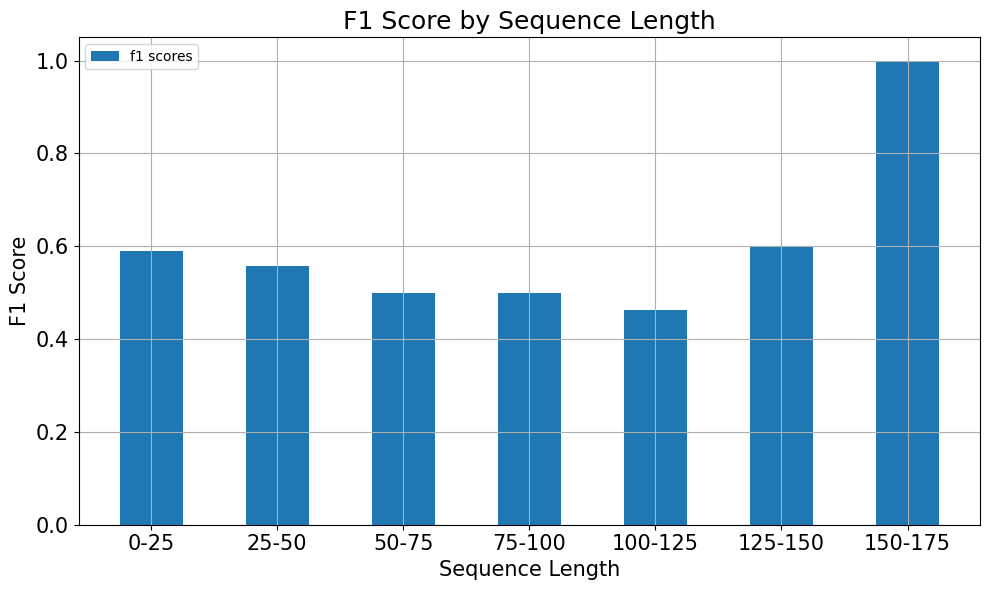

In [37]:
plt.figure(figsize=(10, 6))

bar_width = 0.5

f1_scores_sequence = [f1_score_25, f1_score_50, f1_score_75, f1_score_100, f1_score_125, f1_score_150, f1_score_175]

labels = ['0-25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175']

x = np.arange(len(f1_scores_sequence))
plt.bar(labels, f1_scores_sequence, width=bar_width, label='f1 scores')
#plt.bar(x + bar_width/2, percentages, width=bar_width, label='percentage')

plt.xlabel('Sequence Length', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.yticks(fontsize=15)
plt.title('F1 Score by Sequence Length', fontsize=18)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

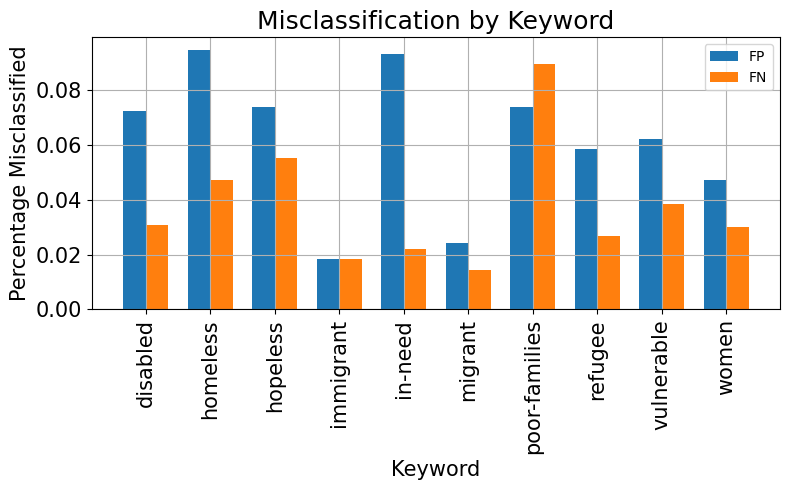

In [36]:
import numpy as np

false_positives_keyword = []
false_negatives_keyword = []

disabled_pred = np.array(test_preds)[test_data['keyword']=='disabled']
disabled_actual = test_label.to_numpy()[test_data['keyword']=='disabled']
disabled_misclassification = 1 - np.sum(disabled_pred==disabled_actual)/len(disabled_actual)
false_positives_keyword.append(np.sum([(disabled_actual==0) & (disabled_pred==1)])/len(disabled_actual))
false_negatives_keyword.append(np.sum([(disabled_actual==1) & (disabled_pred==0)])/len(disabled_pred))

homeless_pred = np.array(test_preds)[test_data['keyword']=='homeless']
homeless_actual = test_label.to_numpy()[test_data['keyword']=='homeless']
homeless_misclassification = 1 - np.sum(homeless_pred==homeless_actual)/len(homeless_actual)
false_positives_keyword.append(np.sum([(homeless_actual==0) & (homeless_pred==1)])/len(homeless_actual))
false_negatives_keyword.append(np.sum([(homeless_actual==1) & (homeless_pred==0)])/len(homeless_pred))

hopeless_pred = np.array(test_preds)[test_data['keyword']=='hopeless']
hopeless_actual = test_label.to_numpy()[test_data['keyword']=='hopeless']
hopeless_misclassification = 1 - np.sum(hopeless_pred==hopeless_actual)/len(hopeless_actual)
false_positives_keyword.append(np.sum([(hopeless_actual==0) & (hopeless_pred==1)])/len(hopeless_actual))
false_negatives_keyword.append(np.sum([(hopeless_actual==1) & (hopeless_pred==0)])/len(hopeless_pred))

immigrant_pred = np.array(test_preds)[test_data['keyword']=='immigrant']
immigrant_actual = test_label.to_numpy()[test_data['keyword']=='immigrant']
immigrant_misclassification = 1 - np.sum(immigrant_pred==immigrant_actual)/len(immigrant_actual)
false_positives_keyword.append(np.sum([(immigrant_actual==0) & (immigrant_pred==1)])/len(immigrant_actual))
false_negatives_keyword.append(np.sum([(immigrant_actual==1) & (immigrant_pred==0)])/len(immigrant_pred))

in_need_pred = np.array(test_preds)[test_data['keyword']=='in-need']
in_need_actual = test_label.to_numpy()[test_data['keyword']=='in-need']
in_need_misclassification = 1 - np.sum(in_need_pred==in_need_actual)/len(in_need_actual)
false_positives_keyword.append(np.sum([(in_need_actual==0) & (in_need_pred==1)])/len(in_need_actual))
false_negatives_keyword.append(np.sum([(in_need_actual==1) & (in_need_pred==0)])/len(in_need_pred))

migrant_pred = np.array(test_preds)[test_data['keyword']=='migrant']
migrant_actual = test_label.to_numpy()[test_data['keyword']=='migrant']
migrant_misclassification = 1 - np.sum(migrant_pred==migrant_actual)/len(migrant_actual)
false_positives_keyword.append(np.sum([(migrant_actual==0) & (migrant_pred==1)])/len(migrant_actual))
false_negatives_keyword.append(np.sum([(migrant_actual==1) & (migrant_pred==0)])/len(migrant_pred))

poor_families_pred = np.array(test_preds)[test_data['keyword']=='poor-families']
poor_families_actual = test_label.to_numpy()[test_data['keyword']=='poor-families']
poor_families_misclassification = 1 - np.sum(poor_families_pred==poor_families_actual)/len(poor_families_actual)
false_positives_keyword.append(np.sum([(poor_families_actual==0) & (poor_families_pred==1)])/len(poor_families_actual))
false_negatives_keyword.append(np.sum([(poor_families_actual==1) & (poor_families_pred==0)])/len(poor_families_pred))

refugee_pred = np.array(test_preds)[test_data['keyword']=='refugee']
refugee_actual = test_label.to_numpy()[test_data['keyword']=='refugee']
refugee_misclassification = 1 - np.sum(refugee_pred==refugee_actual)/len(refugee_actual)
false_positives_keyword.append(np.sum([(refugee_actual==0) & (refugee_pred==1)])/len(refugee_actual))
false_negatives_keyword.append(np.sum([(refugee_actual==1) & (refugee_pred==0)])/len(refugee_pred))

vulnerable_pred = np.array(test_preds)[test_data['keyword']=='vulnerable']
vulnerable_actual = test_label.to_numpy()[test_data['keyword']=='vulnerable']
vulnerable_misclassification = 1 - np.sum(vulnerable_pred==vulnerable_actual)/len(vulnerable_actual)
false_positives_keyword.append(np.sum([(vulnerable_actual==0) & (vulnerable_pred==1)])/len(vulnerable_actual))
false_negatives_keyword.append(np.sum([(vulnerable_actual==1) & (vulnerable_pred==0)])/len(vulnerable_pred))

women_pred = np.array(test_preds)[test_data['keyword']=='women']
women_actual = test_label.to_numpy()[test_data['keyword']=='women']
women_misclassification = 1 - np.sum(women_pred==women_actual)/len(women_actual)
false_positives_keyword.append(np.sum([(women_actual==0) & (women_pred==1)])/len(women_actual))
false_negatives_keyword.append(np.sum([(women_actual==1) & (women_pred==0)])/len(women_pred))


plt.figure(figsize=(8, 5))

categories = ['disabled', 'homeless', 'hopeless', 'immigrant', 'in-need',
'migrant', 'poor-families', 'refugee', 'vulnerable', 'women']
bar_width = 0.35

x = np.arange(len(categories))
plt.bar(x - bar_width/2, false_positives_keyword, width=bar_width, label='FP')
plt.bar(x + bar_width/2, false_negatives_keyword, width=bar_width, label='FN')

plt.xlabel('Keyword', fontsize=15)
plt.ylabel('Percentage Misclassified', fontsize=15)
plt.title('Misclassification by Keyword', fontsize=18)
plt.xticks(x, categories, fontsize=15, rotation=90)
plt.yticks(fontsize=15) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()